In [3]:


import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns
import numpy as np

covid_data=pd.read_csv("us-counties-recent.csv");

newdata=covid_data[covid_data["state"]=="Florida"];

agedata=pd.read_csv("cc-est2019-agesex-12.csv");
newdata2=agedata[agedata["YEAR"]==12];

educ_data=pd.read_csv("ACSST1Y2021.S1501-2022-10-17T192910.csv");

eddat=[];
columnsdat=[i for i in range(1,len(list(educ_data.columns)),12)];
columnsdat.insert(0,0)


eddat2=educ_data[educ_data.columns[columnsdat]]



# print(y) 
# newcovdata=newdata[newdata["deaths"]>=1000];
# sns.relplot(
#     data=newdata["deaths"], x=newdata["county"], y=newdata["deaths"]).set(xticklabels=[],title='Covid deaths per Florida county')


In [3]:
sns.relplot(data=newcovdata["deaths"], x=newcovdata["county"], y=newcovdata["deaths"], hue=newcovdata["county"], size=newcovdata["deaths"],sizes=(10, 100)).set(xticklabels=[], title="Florida Counties with covid deaths over 1000")


NameError: name 'newcovdata' is not defined

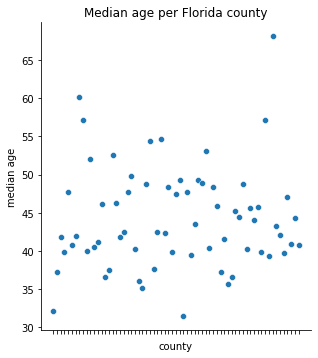

In [3]:
#median age used for the sake of plotting the data. gives an idea of the counties with older population  

sns.relplot(data=newdata2["MEDIAN_AGE_TOT"], x=newdata2["CTYNAME"], y=newdata2["MEDIAN_AGE_TOT"]).set(xticklabels=[],title='Median age per Florida county',xlabel="county",ylabel="median age")



[]
             date     county    state     fips   cases  deaths
324    2022-09-17    Alachua  Florida  12001.0   83099   739.0
326    2022-09-17        Bay  Florida  12005.0   52344   851.0
328    2022-09-17    Brevard  Florida  12009.0  164026  2321.0
329    2022-09-17    Broward  Florida  12011.0  726187  6333.0
331    2022-09-17  Charlotte  Florida  12015.0   44522   900.0
...           ...        ...      ...      ...     ...     ...
94834  2022-10-16  St. Johns  Florida  12109.0   74282   645.0
94835  2022-10-16  St. Lucie  Florida  12111.0   90837  1349.0
94836  2022-10-16     Sumter  Florida  12119.0   27825   647.0
94841  2022-10-16    Volusia  Florida  12127.0  142429  2198.0
94843  2022-10-16     Walton  Florida  12131.0   18875   224.0

[1230 rows x 6 columns]
94777      762.0
94779      862.0
94781     2368.0
94782     6416.0
94784      908.0
94785     1073.0
94786      928.0
94787     1108.0
94788      437.0
94791     3687.0
94792     1427.0
94793      405.0
94802     12

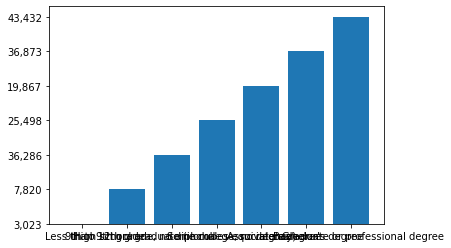

In [20]:
#Education data - looking at the 5 categories 
#normalized to the total population 

eddat2.columns = eddat2.columns.str.replace('County, Florida!!Total!!Estimate','')

totpop=[int(i.replace(",","")) for i in eddat2.iloc[6,1:]];
hs_data=[int(i.replace(",","")) for i in eddat2.iloc[10,1:]]
# less_9=

plt.bar(eddat2.iloc[7:14,0],eddat2.iloc[7:14,1])

norm_hs=[];


for i in range(1,len(totpop)):
    norm_hs.append((hs_data[i]/totpop[i]))
    
# holder=[];
# for i in :
#     holder.drop





print(list(newdata[newdata['county']=="Baker"].index))

newdata3=[];
for j in newdata["county"]:
    k=j+' '   
    b=list(newdata[newdata['county']==j].index)
    if k not in list(eddat2.columns):
        newdata=newdata.drop(b)
        
print(newdata)

v=np.max(newdata["deaths"])
print(newdata.iloc[(1230-41):1231,5])
g=newdata.iloc[(1230-41):1231,5]

z=np.min(g)   
print(z)

f=newdata[newdata['deaths']==v].index
d=newdata[newdata['deaths']==z].index
countymax=newdata.loc[f[-1]].at["county"]
countymin=newdata.loc[d[-1]].at["county"]

    
# print(eddat2[countymax+' '])
# print(eddat2[countymin+' '])

md_eddat=[int(eddat2[countymax+' '][i].replace(",",""))/int(eddat2[countymax+' '][6].replace(",","")) for i in range(7,14)]
# print(md_eddat)
mon_eddat=[int(eddat2[countymin+' '][i].replace(",",""))/int(eddat2[countymin+' '][6].replace(",","")) for i in range(7,14)]
print(mon_eddat)

Text(0.5, 1.0, 'Null distribution of U1 for a sample of 5 per group ')

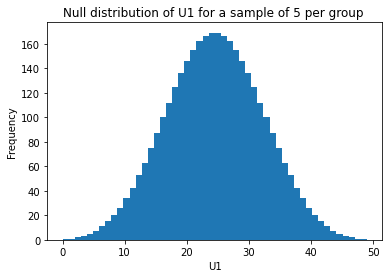

In [19]:

import itertools 

r=len(md_eddat); #number of samples in each group
x=[i for i in itertools.product(["J","B"],repeat=(r*2))]; # for the two groups J and B, finds all possible combinations
#allowing for repeats for a length of 10 
#print(x)

x2=[''.join(x[i]) for i in range(0,len(x))]; #joins the letter combinations to form a string of each combination
# print (x2)

#it returns combinations where the number of letter repeats is greater than 5 but for this there can only be 5 repeats
#per combination so this returns a list of the combinations that only have 5 repeats of each letter 
y3=[x2[i] for i in range(0,len(x2)) if x2[i].count('J')==r and x2[i].count('B')==r ]; 

allcounts=[]; #initializes empty vector to add in the number of wins for each combination 

for i in range(0,len(y3)): #for loop iterates over the list of combinations     
    counts=[abs(x-len(y3[i])) for x in range(0,len(y3[i])) if y3[i][x]=='J']; #for each combination if the letter is a J
    #it returns the absolute value of the index - the length of the combination to return the rank of the J
    allcounts.append((sum(counts)-((r)*((r)+1))/2)); #finds the u value for each combination
    #using R1(sum of ranks) - n(n+1)/2 and adds it to a list 
    

plt.hist(allcounts,bins=50); #plots the u values 

#adds labels to the plots

plt.xlabel('U1')
plt.ylabel('Frequency')
plt.title('Null distribution of U1 for a sample of 5 per group ')

In [24]:
#finding whether the following vectors come from the same distribution using the u statistic 

#vectors with the sample values 

from scipy import stats 

u=[]; #initializing the empty list to place the wins inside 

for i in range(0,len(md_eddat)): #for loop iterating over the length of a 
    wins=[1 for x in range(0,len(md_eddat)) if mon_eddat[i]>md_eddat[x]]; #loops over all elements of b if the element in a is greater than
    #the element in b then a 1 is added to the list 
    u.append(sum(wins)); # adds the number of wins for each element in a to the list u 

u1=sum(u) #sums up the total number of wins for a over b to get u1 
u2=(len(md_eddat)*len(mon_eddat))-sum(u) #finds u2 using the formula u1+u2= n1*n2


#for the two sided p value, finds all u values less than the smaller u value (of u1 and u2) and all u values greater
#than the larger u value (of u1 and u2). Divided by the total number of U values in the distribution 

if u1<u2: 
    p=(len([x for x in allcounts if x<=u1])+len([x for x in allcounts if x>=u2]))/len(allcounts)
else:
    p=(len([x for x in allcounts if x>=u1])+len([x for x in allcounts if x<=u2]))/len(allcounts)

print("U1 (a-b) is",u1,'and U2 is',u2) 
print("the likelihood of a and b being from the same distribution is",p)

print("U and p values from the stats package. U1=",stats.mannwhitneyu(mon_eddat,md_eddat)[0],"U2=",stats.mannwhitneyu(mon_eddat,md_eddat)[0],"and p is",stats.mannwhitneyu(mon_eddat,md_eddat)[1])



U1 (a-b) is 23 and U2 is 26
the likelihood of a and b being from the same distribution is 0.9015151515151515
U and p values from the stats package. U1= 23.0 U2= 23.0 and p is 0.9015151515151516


In [26]:
print(list(newdata2[newdata2['CTYNAME']=="Miami-Dade County"].index))

agedata2=[];



columnsdat2=[i for i in range(39,len(list(newdata2.columns)),3)];
columnsdat2.insert(0,9)
columnsdat2.insert(0,6)
columnsdat2.insert(0,4)


agedata2=newdata2[newdata2.columns[columnsdat2]]
print(agedata2[agedata2['CTYNAME']=="Miami-Dade County"])
o=list(agedata2[agedata2['CTYNAME']=="Miami-Dade County"].index)
# mdage=pd.DataFrame(agedata2.loc[o[-1]])
mdage=[(agedata2[agedata2['CTYNAME']=="Miami-Dade County"].iloc[0,i]+agedata2[agedata2['CTYNAME']=="Miami-Dade County"].iloc[0,i+1])/agedata2[agedata2['CTYNAME']=="Miami-Dade County"].iloc[0,1] for i in range(3,len(list(agedata2[agedata2['CTYNAME']=="Miami-Dade County"].columns))-2,2)]
print(mdage)
monage= [(agedata2[agedata2['CTYNAME']=="Monroe County"].iloc[0,i]+agedata2[agedata2['CTYNAME']=="Monroe County"].iloc[0,i+1])/agedata2[agedata2['CTYNAME']=="Monroe County"].iloc[0,1] for i in range(3,len(list(agedata2[agedata2['CTYNAME']=="Monroe County"].columns))-2,2)]
print(monage)




[515]
               CTYNAME  POPESTIMATE  UNDER5_TOT  AGE04_TOT  AGE59_TOT  \
515  Miami-Dade County      2716940      157229     157229     150127   

     AGE1014_TOT  AGE1519_TOT  AGE2024_TOT  AGE2529_TOT  AGE3034_TOT  ...  \
515       150969       154003       162524       189314       193704  ...   

     AGE4549_TOT  AGE5054_TOT  AGE5559_TOT  AGE6064_TOT  AGE6569_TOT  \
515       197549       195001       189311       155338       133162   

     AGE7074_TOT  AGE7579_TOT  AGE8084_TOT  AGE85PLUS_TOT  MEDIAN_AGE_TOT  
515       108234        84061        63452          63698            40.4  

[1 rows x 22 columns]
[0.11312579593218841, 0.11224833820400892, 0.1294978910097389, 0.13934058168380606, 0.14057616288913263, 0.1414503080671638, 0.10618563531031233, 0.0707763145303172, 0.04679897237333176]
[0.08646332920191842, 0.08041439887912917, 0.1077221533653069, 0.12246052702484238, 0.12489895996120062, 0.1600339494530366, 0.1575281564908121, 0.11201972301557364, 0.0484588026081802]

Text(0.5, 1.0, 'Null distribution of U1 for a sample of 5 per group ')

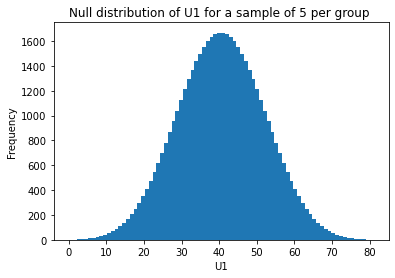

In [12]:
r=len(mdage); #number of samples in each group
x=[i for i in itertools.product(["J","B"],repeat=(r*2))]; # for the two groups J and B, finds all possible combinations
#allowing for repeats for a length of 10 
#print(x)

x2=[''.join(x[i]) for i in range(0,len(x))]; #joins the letter combinations to form a string of each combination
# print (x2)

#it returns combinations where the number of letter repeats is greater than 5 but for this there can only be 5 repeats
#per combination so this returns a list of the combinations that only have 5 repeats of each letter 
y3=[x2[i] for i in range(0,len(x2)) if x2[i].count('J')==r and x2[i].count('B')==r ]; 

allcounts=[]; #initializes empty vector to add in the number of wins for each combination 

for i in range(0,len(y3)): #for loop iterates over the list of combinations     
    counts=[abs(x-len(y3[i])) for x in range(0,len(y3[i])) if y3[i][x]=='J']; #for each combination if the letter is a J
    #it returns the absolute value of the index - the length of the combination to return the rank of the J
    allcounts.append((sum(counts)-((r)*((r)+1))/2)); #finds the u value for each combination
    #using R1(sum of ranks) - n(n+1)/2 and adds it to a list 
    

plt.hist(allcounts,bins=80); #plots the u values 

#adds labels to the plots

plt.xlabel('U1')
plt.ylabel('Frequency')
plt.title('Null distribution of U1 for a sample of 5 per group ')

In [25]:
u=[]; #initializing the empty list to place the wins inside 

for i in range(0,len(mdage)): #for loop iterating over the length of a 
    wins=[1 for x in range(0,len(monage)) if monage[i]>mdage[x]]; #loops over all elements of b if the element in a is greater than
    #the element in b then a 1 is added to the list 
    u.append(sum(wins)); # adds the number of wins for each element in a to the list u 

u1=sum(u) #sums up the total number of wins for a over b to get u1 
u2=(len(mdage)*len(monage))-sum(u) #finds u2 using the formula u1+u2= n1*n2


#for the two sided p value, finds all u values less than the smaller u value (of u1 and u2) and all u values greater
#than the larger u value (of u1 and u2). Divided by the total number of U values in the distribution 

if u1<u2: 
    p=(len([x for x in allcounts if x<=u1])+len([x for x in allcounts if x>=u2]))/len(allcounts)
else:
    p=(len([x for x in allcounts if x>=u1])+len([x for x in allcounts if x<=u2]))/len(allcounts)

print("U1 (a-b) is",u1,'and U2 is',u2) 
print("the likelihood of a and b being from the same distribution is",p)

print("U and p values from the stats package. U1=",stats.mannwhitneyu(monage,mdage)[0],"U2=",stats.mannwhitneyu(monage,mdage)[0],"and p is",stats.mannwhitneyu(monage,mdage)[1])


U1 (a-b) is 39 and U2 is 42
the likelihood of a and b being from the same distribution is 0.9865967365967366
U and p values from the stats package. U1= 39.0 U2= 39.0 and p is 0.9296365245070707


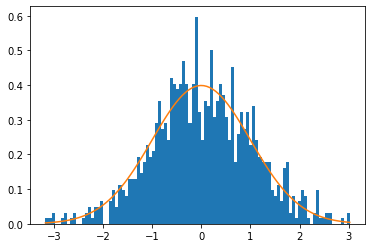

In [7]:
histdata=[];
mu=42;
sigma=np.std(mdage)
for i in range(0,1000):
    randvals=np.random.normal(mu,sigma,len(mdage)); #takes 5 samples from two normal distributions 
    randvals1=np.random.normal(mu,sigma,len(monage));
    
    #finds the pooled standard deviation and the 2 sample t value for the two groups of samples 
    sp=np.sqrt(((len(mdage)-1)*np.std(randvals,ddof=1)**2+(len(monage)-1)*np.std(randvals1,ddof=1)**2)/(len(randvals)+len(randvals1)-
                                                                                      2));
    t=((np.mean(randvals)-np.mean(randvals1))/(sp*np.sqrt((1/len(randvals))+(1/len(randvals1)))));
    histdata.append(t)

#plots the histogram of the two sample t values and the density plot for n=5 
x,bins,patches=plt.hist(histdata,bins=100,density=True);
plt.plot(bins,stats.norm.pdf(bins))


In [17]:
n1=len(mdage); #number of samples 
n2=len(monage);


std1=np.std(mdage,ddof=1)/agedata2[agedata2['CTYNAME']=="Miami-Dade County"].iloc[0,1]; #standard deviation for both groups of samples 
std2=np.std(monage,ddof=1)/agedata2[agedata2['CTYNAME']=="Monroe County"].iloc[0,1];
sp=np.sqrt(((n1-1)*std1**2+(n2-1)*std2**2)/(n1+n2-2));
tval_2sample=((np.mean(mdage)/agedata2[agedata2['CTYNAME']=="Miami-Dade County"].iloc[0,1]-np.mean(monage)/agedata2[agedata2['CTYNAME']=="Monroe County"].iloc[0,1])/(sp*np.sqrt((1/n1)+(1/n2))))
print(tval_2sample)
p=(sum(histdata>=tval_2sample )/1000)*2 #to account for the negative t value - multiply the p value by 2 
print("The likelihood that the heights are from populations with the same mean is",p)
print("P value from the stats package",stats.ttest_ind(mdage,monage)[1])

1.2070680545297342e-15
The likelihood that the heights are from populations with the same mean is 1.0
P value from the stats package 9.52911929887523e-16


<AxesSubplot:ylabel='Count'>

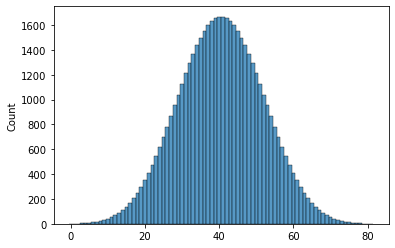

In [8]:
# Set sample size, asssuming an equal # of samples from both groups
n = len(mdage);

# Get all possible combinations and make list to an array
tmp = list(itertools.product([0,1], repeat=2*n))
tmp = np.array(tmp).reshape(-1,2*n)

# Keep only combinations that makes sense. I.e., combos that have an equal # of 
# 0s and 1s
Keep = (np.sum(tmp==0,axis =1)==n) & (np.sum(tmp==1,axis=1)==n);
all_combos = tmp[Keep,:];
# print(len(all_combos))
# print(all_combos)

# Calculate U1 for each possible combination
R1 = [] # As a list

for m in np.arange(0,len(all_combos)):
    tmp = np.sum(np.where(all_combos[m,:]==0)); # Get position of 0 in each row
    tmp = tmp + n; 
    R1.append(tmp)

R1 = np.array(R1) #make back into an array.

#print(R1)
U1 = R1-(n*(n+1))/2
#print(U1)
sns.histplot(U1, discrete = True)




In [29]:
print(stats.mannwhitneyu(monage,mdage))
print(sum(U1<=39)/len(U1)*2)

MannwhitneyuResult(statistic=39.0, pvalue=0.9296365245070707)
0.9314273961332785


In [63]:
from numpy.linalg import inv
import statsmodels.api as sm

for j in agedata2["CTYNAME"]:
    k=j.replace('County','')  
    b=list(agedata2[agedata2['CTYNAME']==j].index)
    if k not in list(eddat2.columns):
        agedata2=agedata2.drop(b)
# print(agedata2)

totpop=[int(i.replace(",","")) for i in eddat2.iloc[6,1:42]];
bachdata=[int(i.replace(",","")) for i in eddat2.iloc[15,1:42]]
print(bachdata)

bachperc=[1 if (bachdata[i]/totpop[i])>0.305 else 0 for i in range(0,len(bachdata))]

deathdat=[];
deathdat=pd.DataFrame(deathdat)
deathdat["deaths"]=newdata.iloc[(1230-41):1231,5]
deathdat["age"]=[1 if x>42 else 0 for x in agedata2["MEDIAN_AGE_TOT"]]
deathdat["education"]=bachperc
print(deathdat)

X=np.c_[np.ones(len(deathdat)),deathdat["age"],deathdat["education"],np.multiply(deathdat["age"],deathdat["education"])]
tmp=inv(np.matmul(np.transpose(X),X))
intercept,slope1,slope2,slope3=tmp @np.transpose(X) @ deathdat["deaths"]

print(slope1, slope2,slope3, intercept)

import statsmodels.api as sm
# model=sm.OLS(cardata["mpg"],sm.add_constant(cardata[["Group1","Group2"]])).fit()


model=sm.OLS(deathdat["deaths"],X).fit()
print(model.summary())

[80305, 38646, 152992, 496402, 41984, 26465, 42356, 120000, 8939, 231410, 61139, 28970, 32943, 14659, 379756, 43243, 80097, 184904, 85113, 111508, 66810, 43982, 617900, 23999, 24281, 51670, 357981, 74976, 439448, 120715, 275075, 110463, 5809, 100707, 68655, 47422, 140191, 145486, 42981, 109682, 22756]
        deaths  age  education
94777    762.0    0          1
94779    862.0    0          0
94781   2368.0    1          1
94782   6416.0    0          1
94784    908.0    1          0
94785   1073.0    1          0
94786    928.0    0          0
94787   1108.0    1          1
94788    437.0    0          0
94791   3687.0    0          1
94792   1427.0    0          0
94793    405.0    1          1
94802   1218.0    1          0
94803    754.0    1          0
94804   4182.0    0          1
94806    726.0    1          1
94810   1687.0    1          0
94811   2398.0    1          1
94812    743.0    0          1
94816   1620.0    1          1
94817   2334.0    1          0
94818    714.0 